In [13]:
import torch
import numpy as np
from tqdm import tqdm 
from time import sleep 
import matplotlib.pyplot as plt


from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim 
import torch.nn.functional as F

In [14]:
def plotting_losses(cnn, cnn_batch_norm):
    plt.plot(cnn.detach(), 'r', label="CNN")
    plt.plot(cnn_batch_norm.detach(), 'k', label="CNN with Batch Norm")
    plt.legend()
    plt.show()
    
def acc_plot(cnn, cnn_batch_norm):
    plt.plot(cnn, 'r', label="CNN")
    plt.plot(cnn_batch_norm, 'k', label="CNN with Batch Norm")
    plt.legend()
    plt.show()
    
def plot_images(images):
    for image in images:
        plt.figure()
        plt.imshow(image)
    

The transforms chosen by us are `RandomHorizontalFlip`, `RandomRotation`, `Random Affine`, `ColorJitter`and finally `Normalize`.
These transforms were chosen because they do not drastically change the features of the image but make the model more robust since the photos are now randomly rotated and flipped thus increasing the datatset and the model gets to learn the features better.


In [15]:
class Dataset:
    def __init__(self, images: torch.Tensor, labels: torch.Tensor, mode: str):
        self.mode = mode
        self.images = images
        self.labels = labels
        self.train_transform = transforms.Compose([transforms.ToPILImage(),
                                                   transforms.RandomHorizontalFlip(0.3), # FLips the image w.r.t horizontal axis
                                                   transforms.RandomRotation(10),     #Rotates the image to a specified angel
                                                   transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
                                                   transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
                                                   transforms.ToTensor(), # comvert the image to tensor so that it can work with torch
                                                   transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                                                        std=[0.5, 0.5, 0.5])]) #Normalize all the images
                                                  
 
 
        self.test_transform = transforms.Compose([transforms.ToPILImage(),
                                                   transforms.ToTensor(),
                                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                                 ])
    def __len__(self):
        a = len(self.labels)
        return a
    
    def __getitem__(self, index):
#         image = self.images[index]
        image = self.images[index]
        label = self.labels[index]
        if self.mode == "train":
            image = self.train_transform(image)
        elif self.mode == "test":
            image = self.test_transform(image)
        return image, label

In [16]:
dataset_x = datasets.CIFAR10(root = "cifar/", train = True, download = False)
dataset_y = datasets.CIFAR10(root = "cifar/", train = False, download = False)
train_dataset = Dataset(dataset_x.data, dataset_x.targets, "train")
test_dataset = Dataset(dataset_y.data, dataset_y.targets, "test")

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 128, shuffle = True, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 128, shuffle = True, pin_memory=True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


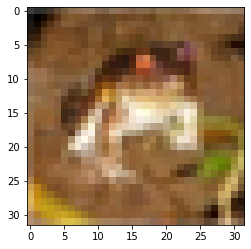

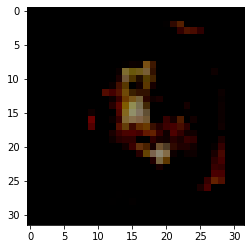

In [17]:
image_before = dataset_x[0][0]
image_after = train_dataset[0][0].transpose(0,2)
images = [image_before, image_after]
plot_images(images)

In [23]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 32, 3)
        
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.conv4 = nn.Conv2d(64, 64, 3)

        x = torch.randn(32,32,3).view(-1,3,32,32)
        
        self._to_linear = None 
        self.convs(x)
        self.fc = nn.Linear(self._to_linear, 10)
        
    def convs(self,x):
        # Block 1
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x , (2,2))
        
        #Block 2
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x , (2,2))
        if self._to_linear is None:
            self._to_linear = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
        return x
    
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = self.fc(x)
        return x

In [24]:
def train(model, optimizer, dataloader):
    for x,y in dataloader:
        x, y = x.to('cuda:0'), y.to('cuda:0')
        optimizer.zero_grad()
        prediction = model.forward(x)
        loss = nn.CrossEntropyLoss()
        output_loss = loss(prediction, y)
        output_loss.backward()
        optimizer.step()
    return output_loss

def accuracy(model, dataloader):
    hits = 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to('cuda:0'), y.to('cuda:0')
            prediction = model.forward(x)
            prediction = torch.argmax(prediction, dim=1)
            hits += (prediction == y).count_nonzero()
    acc = hits / len(dataloader.dataset)
    return acc

In [25]:
def training(model_factory, dataloader, optimizer_factory, epochs):
    losses = torch.zeros(epochs)
    accuracies = torch.zeros(epochs)
    model = model_factory.to('cuda:0')
    optimizer = optimizer_factory
    
    for epoch in tqdm(range(epochs)):
        losses[epoch] = train(model, optimizer, dataloader)
        accuracies[epoch] = accuracy(model, test_loader)
        sleep(0.1)
        print(f"Loss of Epoch {epoch} is {losses[epoch]}")
        print(f"Accuracy of Epoch {epoch} is {accuracies[epoch]}")
    return losses, accuracies

In [26]:
model = Network()
optimizer = optim.Adam(model.parameters(), lr=0.0005, betas=(0.9, 0.95))
losses, accuracies = training(model, train_loader, optimizer, 25) 

  4%|▍         | 1/25 [00:29<11:43, 29.30s/it]

Loss of Epoch 0 is 3.0540308952331543
Accuracy of Epoch 0 is 0.06610000133514404


  4%|▍         | 1/25 [00:32<13:09, 32.90s/it]


KeyboardInterrupt: 

In [ ]:
class Network_Norm(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 32, 3)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.conv4 = nn.Conv2d(64, 64, 3)
        self.bn2 = nn.BatchNorm2d(64)
        
        x = torch.randn(32,32,3).view(-1,3,32,32)
        
        self._to_linear = None 
        self.convs(x)
        
        self.fc = nn.Linear(self._to_linear, 10)
        
    def convs(self,x):
        # Block 1
        x = F.relu(self.conv1(x))
        x = F.relu(self.bn1(self.conv2(x)))
        x = F.max_pool2d(x , (2,2))
        
        #Block 2
        x = F.relu(self.conv3(x))
        x = F.relu(self.bn2(self.conv4(x)))
        x = F.max_pool2d(x , (2,2))
        if self._to_linear is None:
            self._to_linear = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
        return x
    
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = self.fc(x)
        return x
    
    def convs_test(self,x):
        # Block 1
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x , (2,2))
        
        #Block 2
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x , (2,2))
        if self._to_linear is None:
            self._to_linear = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
        return x
    
    def forward_test(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = self.fc(x)
        return x

In [57]:
def train_fc(model, optimizer, dataloader, batch:bool):
    for x, y in dataloader:
        x, y = x.to('cuda:0'), y.to('cuda:0')
        optimizer.zero_grad()
        if batch == True:
            prediction = model.forward(x)
        else: 
            prediction = model.forward_test(x)
        loss = nn.CrossEntropyLoss()
        output_loss = loss(prediction, y.to(torch.long))
        output_loss.backward()
        optimizer.step()
    return output_loss

def accuracy_fc(model, dataloader):
    hits = 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to('cuda:0'), y.to('cuda:0')
            prediction = model.forward_test(x)
            prediction = torch.argmax(prediction, dim=1)
            hits += (prediction == y).count_nonzero()
    acc = hits / len(dataloader.dataset)
    return acc

In [58]:
def batch_norm(model_factory, optimizer_factory, dataloader, epochs):
    losses = torch.zeros(epochs)
    accuracies = torch.zeros(epochs)
    model = model_factory.to('cuda:0')
    optimizer = optimizer_factory
    for epoch in tqdm(range(epochs)):
        losses[epoch] = train_fc(model, optimizer, dataloader, True)
        accuracies[epoch] = accuracy_fc(model, test_loader)
        print(f"The loss of {epoch} is {losses[epoch]}")
        print(f"The accuracy of {epoch} is {accuracies[epoch]}")
        sleep(0.1)
    return losses, accuracies

In [59]:
model1 = Network_Norm()
optimizer1  = optim.Adam(model1.parameters(), lr= 0.0005, betas= (0.9, 0.95))
batch_losses, batch_accuracies = batch_norm(model1, optimizer1, train_loader, 25)

  4%|▍         | 1/25 [00:28<11:12, 28.02s/it]

The loss of 0 is 1.1814892292022705
The accuracy of 0 is 0.6021999716758728


  8%|▊         | 2/25 [00:56<10:47, 28.16s/it]

The loss of 1 is 0.9495824575424194
The accuracy of 1 is 0.6739999651908875


 12%|█▏        | 3/25 [01:24<10:17, 28.06s/it]

The loss of 2 is 1.047180414199829
The accuracy of 2 is 0.699400007724762


 16%|█▌        | 4/25 [01:52<09:47, 28.00s/it]

The loss of 3 is 0.9037259221076965
The accuracy of 3 is 0.7055000066757202


 20%|██        | 5/25 [02:20<09:19, 27.97s/it]

The loss of 4 is 0.6764065027236938
The accuracy of 4 is 0.7337999939918518


 24%|██▍       | 6/25 [02:48<08:51, 27.96s/it]

The loss of 5 is 0.8072800636291504
The accuracy of 5 is 0.7328999638557434


 28%|██▊       | 7/25 [03:15<08:22, 27.92s/it]

The loss of 6 is 0.8375244140625
The accuracy of 6 is 0.7515000104904175


 32%|███▏      | 8/25 [03:43<07:54, 27.92s/it]

The loss of 7 is 0.7415975332260132
The accuracy of 7 is 0.761900007724762


 36%|███▌      | 9/25 [04:11<07:26, 27.91s/it]

The loss of 8 is 0.6530089974403381
The accuracy of 8 is 0.772599995136261


 40%|████      | 10/25 [04:39<06:57, 27.86s/it]

The loss of 9 is 0.7447183132171631
The accuracy of 9 is 0.762999951839447


 44%|████▍     | 11/25 [05:06<06:28, 27.77s/it]

The loss of 10 is 0.6295381188392639
The accuracy of 10 is 0.7710999846458435


 48%|████▊     | 12/25 [05:34<06:00, 27.73s/it]

The loss of 11 is 0.5532045960426331
The accuracy of 11 is 0.7780999541282654


 52%|█████▏    | 13/25 [06:02<05:32, 27.71s/it]

The loss of 12 is 0.8301677703857422
The accuracy of 12 is 0.7780999541282654


 56%|█████▌    | 14/25 [06:30<05:05, 27.77s/it]

The loss of 13 is 0.7319682836532593
The accuracy of 13 is 0.7828999757766724


 60%|██████    | 15/25 [06:58<04:38, 27.84s/it]

The loss of 14 is 0.7813944816589355
The accuracy of 14 is 0.7831999659538269


 64%|██████▍   | 16/25 [07:26<04:10, 27.88s/it]

The loss of 15 is 0.7039584517478943
The accuracy of 15 is 0.7876999974250793


 68%|██████▊   | 17/25 [07:53<03:42, 27.86s/it]

The loss of 16 is 0.6848110556602478
The accuracy of 16 is 0.7912999987602234


 72%|███████▏  | 18/25 [08:21<03:14, 27.82s/it]

The loss of 17 is 0.645480751991272
The accuracy of 17 is 0.7902999520301819


 76%|███████▌  | 19/25 [08:49<02:47, 27.87s/it]

The loss of 18 is 0.7258626818656921
The accuracy of 18 is 0.7930999994277954


 80%|████████  | 20/25 [09:17<02:19, 27.90s/it]

The loss of 19 is 0.771753191947937
The accuracy of 19 is 0.7950999736785889


 84%|████████▍ | 21/25 [09:45<01:51, 27.95s/it]

The loss of 20 is 0.6597365140914917
The accuracy of 20 is 0.8032000064849854


 88%|████████▊ | 22/25 [10:13<01:23, 27.98s/it]

The loss of 21 is 0.6381834745407104
The accuracy of 21 is 0.7886999845504761


 92%|█████████▏| 23/25 [10:41<00:56, 28.01s/it]

The loss of 22 is 0.543421745300293
The accuracy of 22 is 0.7982999682426453


 96%|█████████▌| 24/25 [11:09<00:27, 27.98s/it]

The loss of 23 is 0.5452402830123901
The accuracy of 23 is 0.804099977016449


100%|██████████| 25/25 [11:37<00:00, 27.91s/it]

The loss of 24 is 0.6620484590530396
The accuracy of 24 is 0.8029999732971191


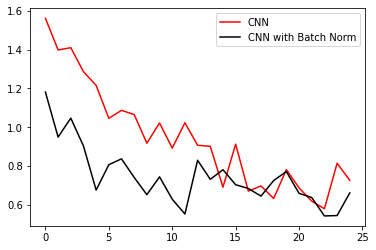

In [66]:
plotting_losses(losses, batch_losses)

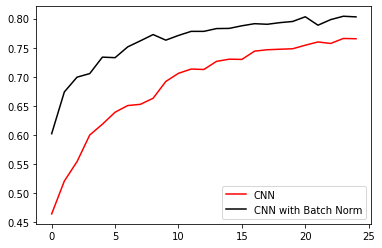

In [67]:
acc_plot(accuracies, batch_accuracies)

Here we applied Batch Norm and as we can see the accuracies have increased 